In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams

In [2]:
ts_df = pd.read_csv("cleaned_data/model_data_clean.csv", index_col=0)

In [3]:
ts_df.head()

,id,host_id,host_listings_count,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,...,neighborhood_Whites_Creek,property_type_Condominium,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,inventory,avg_home_value
2015-06-01,4.911123e+06,1.847859e+07,2.355372,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,...,3.0,1.0,78.0,11.0,1.0,0.0,39.0,3.0,121,194391.913462
2015-07-01,4.585624e+06,1.588542e+07,10.465015,37202.203096,36.157222,-86.767316,4.607430,1.500310,2.308978,202.349226,...,9.0,33.0,1048.0,100.0,18.0,0.0,451.0,18.0,1615,195615.557692
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,196760.903846
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,198188.798077
2015-10-01,5.435875e+06,1.857827e+07,11.842180,37201.418483,36.156564,-86.767390,4.795735,1.528910,2.406161,200.524171,...,23.0,54.0,1360.0,130.0,51.0,0.0,566.0,30.0,2110,199658.365385


# Set Time Series Index

In [4]:
ts_df.reset_index(inplace=True)
ts_df['index'] = pd.to_datetime(ts_df['index'],format='%Y/%m/%d')
ts_df.set_index('index', inplace=True)
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 49 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   host_listings_count               39 non-null     float64
 3   zipcode                           39 non-null     float64
 4   latitude                          39 non-null     float64
 5   longitude                         39 non-null     float64
 6   accommodates                      39 non-null     float64
 7   bathrooms                         39 non-null     float64
 8   beds                              39 non-null     float64
 9   price                             39 non-null     float64
 10  guests_included                   39 non-null     float64
 11  minimum_nights                    39 non-null     flo

# Deal with Missing Time Series Values

## Visualize the trend

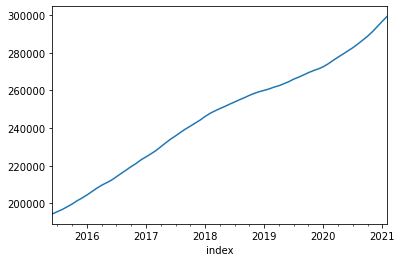

In [5]:
ts_df.avg_home_value.plot();

Appears to be trend without seasonality

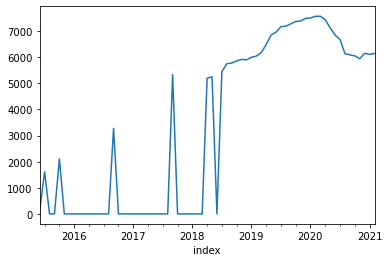

In [6]:
ts_df.inventory.plot();

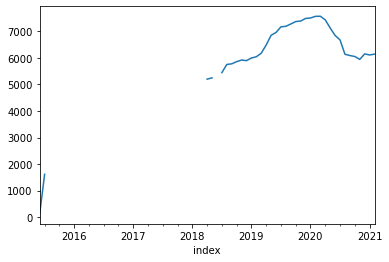

In [7]:
ts_df['inventory'] = ts_df['inventory'].replace(0,np.nan)
ts_df.inventory.plot();

Data appears to be missing throughout 2016 and 2017. Let's see what looking at just 2018 onward looks like.

## Focus on Dates after 2018

In [8]:
post_18_ts_df = ts_df['2018':]

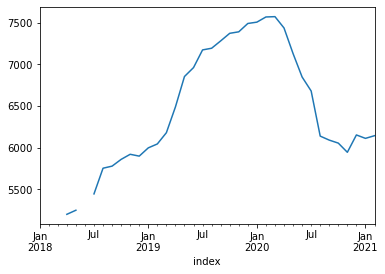

In [9]:
post_18_ts_df.inventory.plot();

There are still a handful of missing values. Let's use linear interpolation to fill in these values.

In [10]:
post_18_ts_df = post_18_ts_df.interpolate()

In [11]:
post_18_ts_df.dropna(inplace=True)

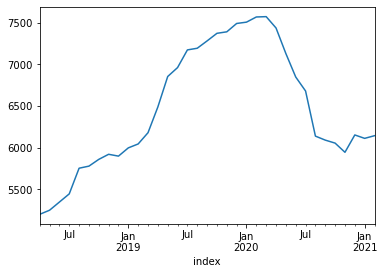

In [12]:
post_18_ts_df.inventory.plot();

## Interpolate Full Dataset

In [13]:
ts_df.interpolate(inplace=True)

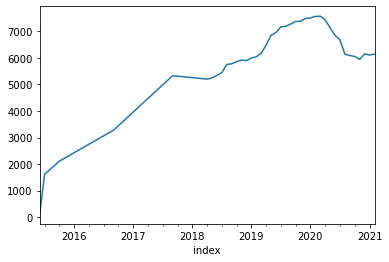

In [14]:
ts_df.inventory.plot();

We wil try modeling with both versions of the dataset.

# Explore Time Series

## Decompose Time Series

In [145]:
result = seasonal_decompose(ts_df['avg_home_value'], model='add')

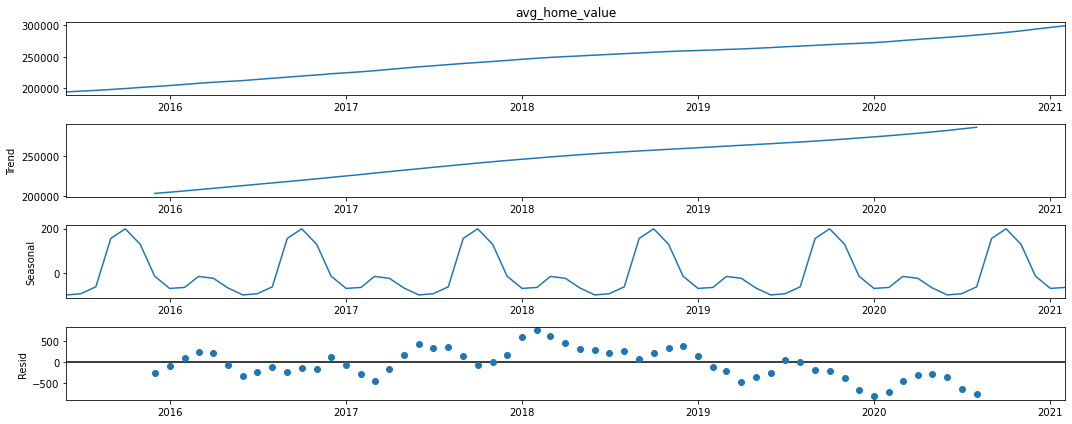

In [146]:
fig = result.plot()
fig.set_figheight(6)

In [183]:
decomposition = seasonal_decompose(ts_df['avg_home_value'])

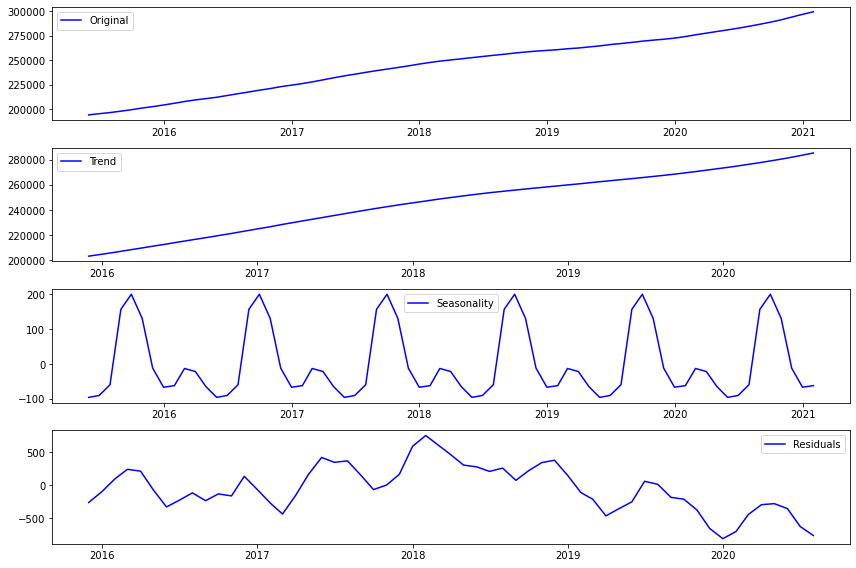

In [185]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ts_df['avg_home_value'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

## Check Time Series stationarity

In [147]:
def stationarity_check(ts):
    roll_mean = ts.rolling(window=8, center=False).mean()
    roll_std = ts.rolling(window=8, center=False).std()
    fig = plt.figure(figsize=(8,5))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    return dfoutput

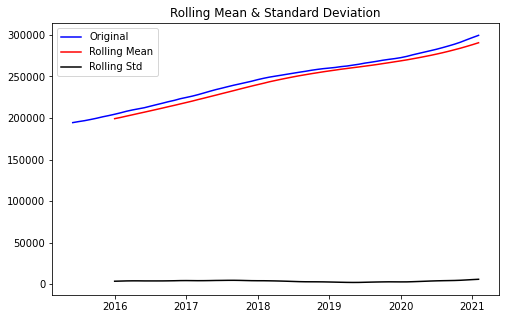

Test Statistic                  0.729425
p-value                         0.990407
#Lags Used                     11.000000
Number of Observations Used    57.000000
dtype: float64

In [149]:
ts = ts_df['avg_home_value']
stationarity_check(ts)

Because the p-value is much greater than 0.05, we cannot reject the null hypothesis that the data is not stationary.

## Look at ACF and PACF plots

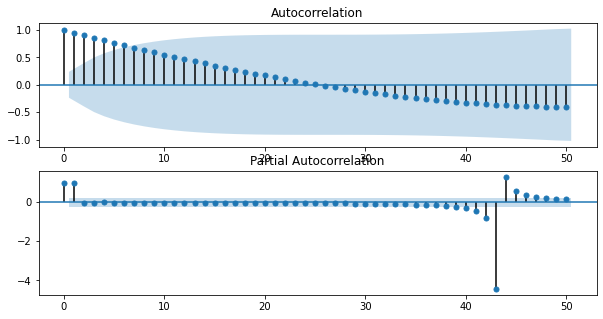

In [150]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(ts, lags=50, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(ts, lags=50, ax=ax[1])
plt.show()

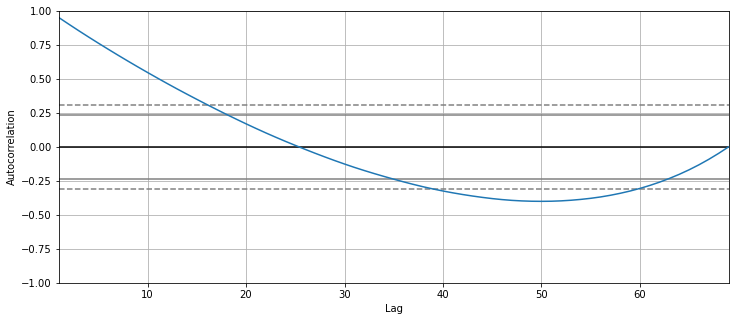

In [186]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(ts);

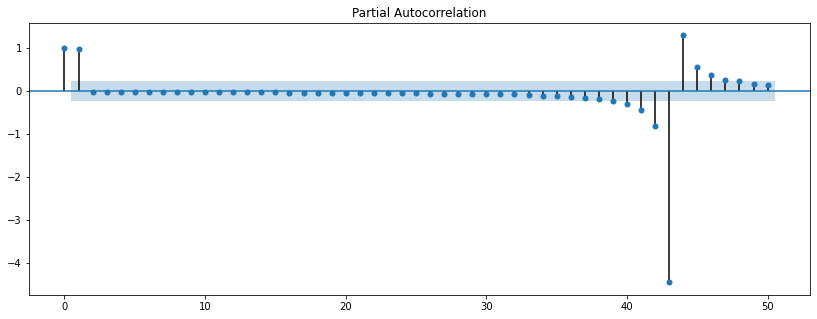

In [187]:
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_pacf(ts, lags=50);

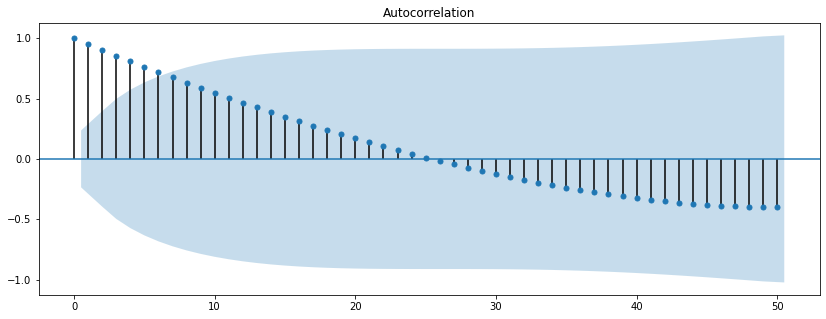

In [188]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5

plot_acf(ts, lags=50);

# ARMA Time Series Model

* Come back to*

## Differencing

In [189]:
ts_diff = ts.diff(periods=1)
ts_diff.dropna(inplace=True)

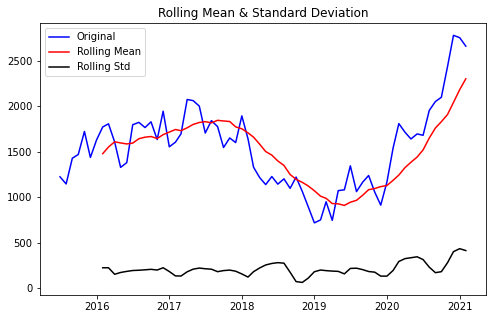

Test Statistic                 -3.812048
p-value                         0.002786
#Lags Used                     11.000000
Number of Observations Used    56.000000
dtype: float64

In [190]:
stationarity_check(ts_diff)

We can now reject the null hypothesis and confirm the data is stationary.

# SARIMA Time Series Model

## Set up Data for Modeling

In [41]:
home_values = ts_df['avg_home_value']

index
2015-06-01    194391.913462
2015-07-01    195615.557692
2015-08-01    196760.903846
2015-09-01    198188.798077
2015-10-01    199658.365385
                  ...      
2020-10-01    288751.259615
2020-11-01    291187.711538
2020-12-01    293967.509615
2021-01-01    296722.163462
2021-02-01    299383.230769
Name: avg_home_value, Length: 69, dtype: float64

In [42]:
X = home_values.values

In [172]:
train_size = int(len(home_values)*.7)
test_size = int(len(home_values)-train_size)
train, test = home_values[0:train_size], home_values[train_size:len(home_values)]
print('Observations: %d' % (len(home_values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 69
Training Observations: 48
Testing Observations: 21


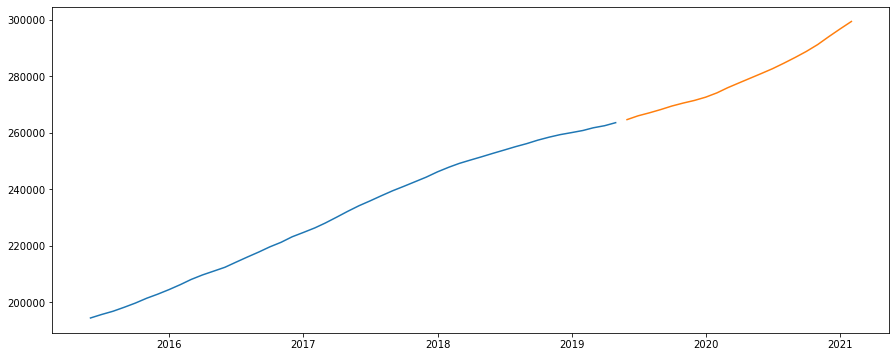

In [73]:
plt.plot(train)
plt.plot(test)
plt.show()

## Parameter Selection for the SARIMA Model

In [136]:
# set seasonal s equal to 12
s=12
# allow p, d and q to take any value from 0 to 1
p = d = q = range(0,2)

# generate all combinations of p,d and q
pdq = list(itertools.product(p, d, q))

# generate all combinations including seasonal combinations
pdqs = [(x[0], x[1], x[2], s) for x in pdq]

In [137]:
# run grid with parameters above and select best AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(train,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))            

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 1297.239113096985
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 972.5714206699976
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 790.9241715168462
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 518.6186808167402
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 705.5121000001735
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1056.9600134983918
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 470.4906257327658
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 423.0896166700872
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 40192.53156959755
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = 422712.9546217003
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 751.1323626812468
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 485.06544749176743
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 962.78631126914
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = 543241.3403391597
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 523.9370286434416
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 482.0115866640204
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 806.57025865104

In [138]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic            295.15
Name: 63, dtype: object

In [139]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

In [140]:
seasonal_order

(1, 1, 1, 12)

## Fit SARIMA Model

In [141]:
SARIMA_MODEL = SARIMAX(train,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [142]:
output = SARIMA_MODEL.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -142.575
Date:                            Wed, 31 Mar 2021   AIC                            295.150
Time:                                    14:42:40   BIC                            300.373
Sample:                                06-01-2015   HQIC                           296.284
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9967      0.105      9.455      0.000       0.790       1.203
ma.L1         -0.1931      0.167     -1.160      0.246      -0.519       0.133
ar.S.L12      -0.6947      0.207     -3.350      0.001      -1.101      -0.288
ma.S.L12      -0.0242      0.061     -0.397      0.691      -0.144       0.095
sigma2       4.55e+04    1.9e+04      2.394      0.017    8249.655    8.27e+04
===================================================================================
Ljung-Box (Q):                       27.96   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.11   Prob(JB):                         0.70
Heteroskedasticity (H):               0.94   Skew:                            -0.26
Prob(H) (two-sided):                  0.94   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
coef = output.params
coef

ar.L1           0.996722
ma.L1          -0.193086
ar.S.L12       -0.694686
ma.S.L12       -0.024208
sigma2      45495.866474
dtype: float64

## Run Model Diagnostics

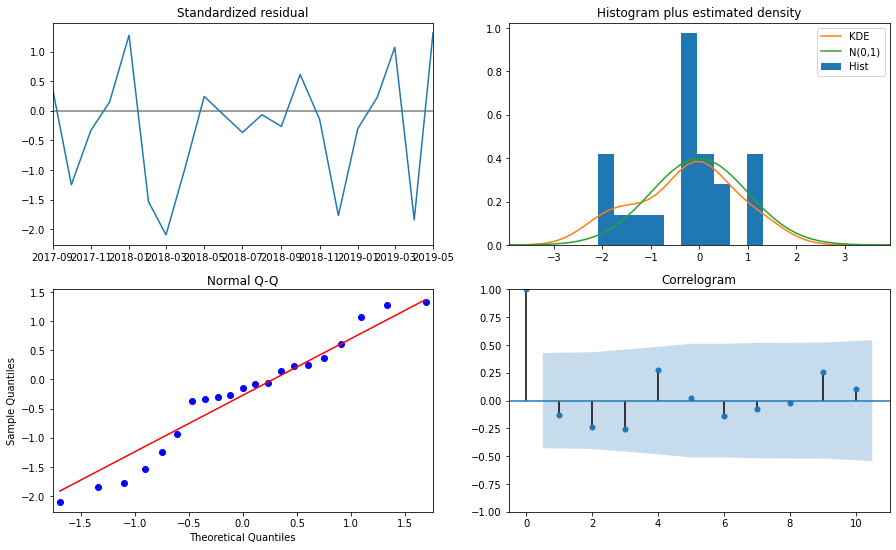

In [144]:
output.plot_diagnostics(figsize=(15,9));

It appears the residuals are normally distributed based on the KDE plot and the qq-plot, although there could be some violations at either tail.
The residuals appear to have white noise and not showing signs of seasonality. The residuals are also not highly correlated with themselves based on the autocorrelation plot.

## Make Predictions for Test Set

In [151]:
history = [train[i] for i in range(len(train))]

In [152]:
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i]*history[-i]
    return yhat

In [153]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
predictions = []
for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmes = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6898.743


## One-Step Ahead Forecasting

In [154]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_conf = pred.conf_int()

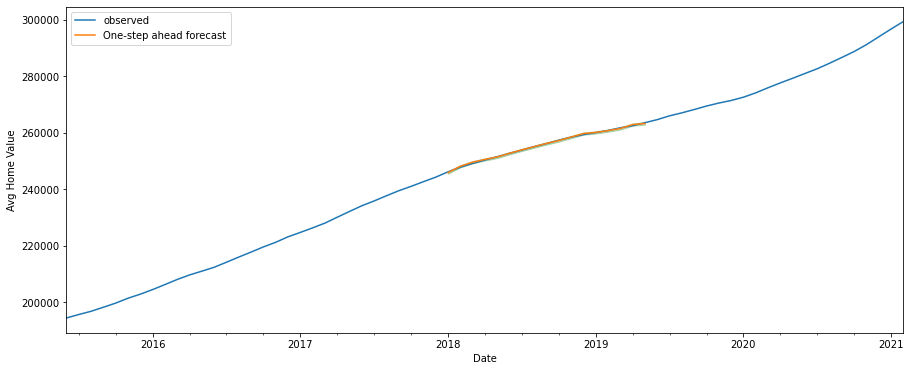

In [155]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [156]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

228.38933825163429


## Dynamic Forecast

In [157]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

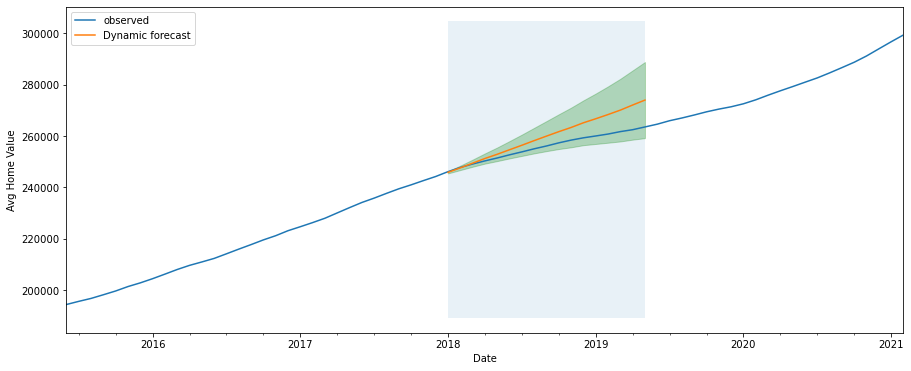

In [158]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g',alpha=0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [159]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

5374.869660908402


Much higher RMSE using a dynamic model.

## Predicting Future Values

In [160]:
prediction = output.get_forecast(steps=60)
pred_conf = prediction.conf_int()

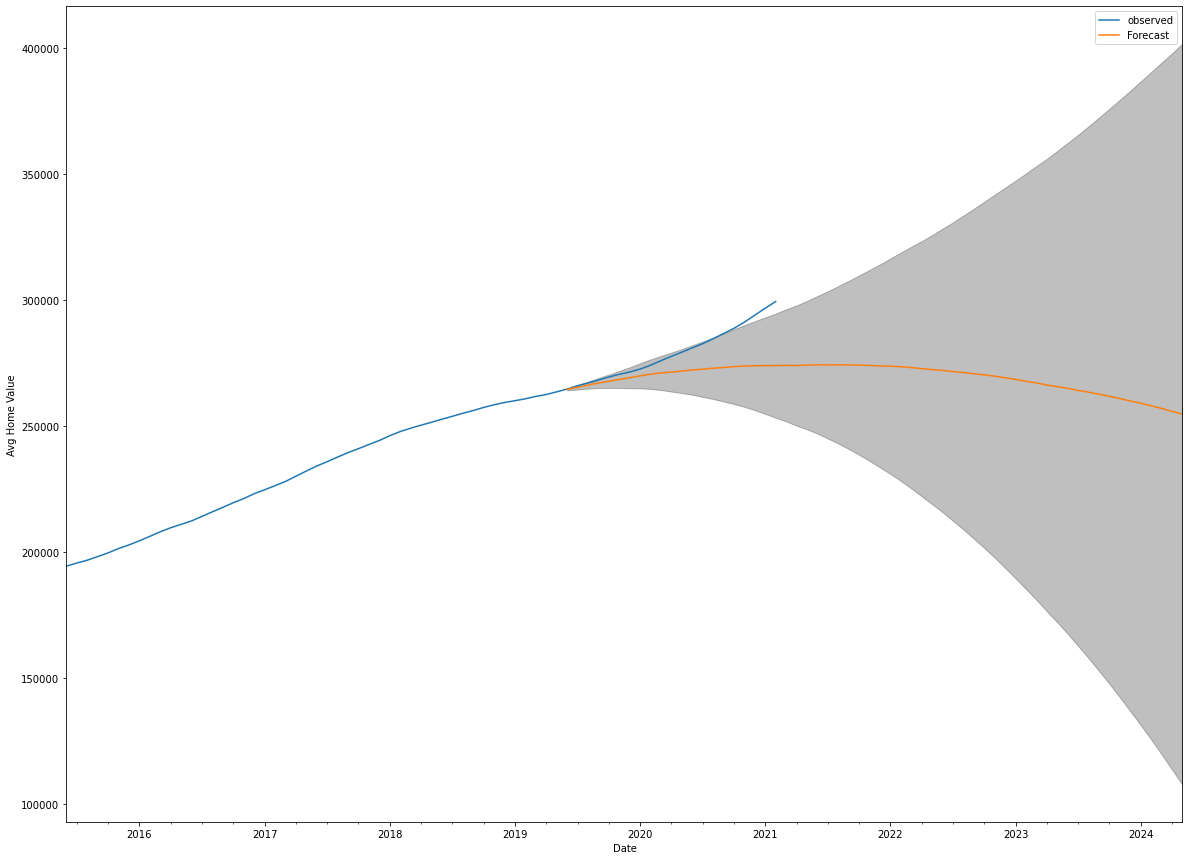

In [161]:
ax = home_values.plot(label='observed', figsize=(20,15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

# SARIMAX Time Series Model

## Parameter Selection for SARIMAX Model

For our exogenous parameters in our SARIMAX model, we will use the most important features selected from our regression model.

In [95]:
final_reg_df = pd.read_csv("cleaned_data/final_reg_features.csv", index_col=0)

In [101]:
features = list(final_reg_df.columns)

In [103]:
final_time_series_df = ts_df[features]
post_18_final_time_series_df = post_18_ts_df[features]

In [104]:
final_time_series_df

,avg_home_value,bathrooms,number_of_reviews,host_is_superhost,neighborhood_North_Nashville
index,,,,,
2015-06-01,194391.913462,1.450413,17.206612,23,6.0
2015-07-01,195615.557692,1.500310,16.536223,285,49.0
2015-08-01,196760.903846,1.509843,16.929362,0,0.0
2015-09-01,198188.798077,1.519377,17.322501,0,0.0
2015-10-01,199658.365385,1.528910,17.715640,434,76.0
...,...,...,...,...,...
2020-10-01,288751.259615,1.912799,53.884558,3533,673.0
2020-11-01,291187.711538,1.907149,54.217325,3429,689.0
2020-12-01,293967.509615,1.906143,53.611572,3495,680.0


In [105]:
home_values = final_time_series_df['avg_home_value']
exog = final_time_series_df.drop('avg_home_value', axis=1)

In [107]:
train_size = int(len(home_values)*.7)
train, test = home_values[0:train_size], home_values[train_size:len(X)]
train_exog, test_exog = exog[0:train_size], exog[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 69
Training Observations: 48
Testing Observations: 21


In [109]:
ans = []
for comb in pdq:
    for combs in pdqs:
        mod = SARIMAX(train, train_exog,
                     order=comb,
                     seasonal_order=combs,
                     enforce_stationarity=False,
                     enforce_invertibility=False)
        output = mod.fit()
        ans.append([comb, combs, output.aic])
        print('ARIMA {} x {}12: AIC = {}'.format(comb, combs, output.aic))         

ARIMA (0, 0, 0) x (0, 0, 0, 12)12: AIC = 824.980815145348
ARIMA (0, 0, 0) x (0, 0, 1, 12)12: AIC = 1488.402946868504
ARIMA (0, 0, 0) x (0, 1, 0, 12)12: AIC = 616.3860974640396
ARIMA (0, 0, 0) x (0, 1, 1, 12)12: AIC = 398.2244883248561
ARIMA (0, 0, 0) x (1, 0, 0, 12)12: AIC = 637.2604599022843
ARIMA (0, 0, 0) x (1, 0, 1, 12)12: AIC = 1173.5478099243894
ARIMA (0, 0, 0) x (1, 1, 0, 12)12: AIC = 423.16222466981503
ARIMA (0, 0, 0) x (1, 1, 1, 12)12: AIC = 400.94310484298757
ARIMA (0, 0, 1) x (0, 0, 0, 12)12: AIC = 782.5917880995216
ARIMA (0, 0, 1) x (0, 0, 1, 12)12: AIC = 3201.2486931430253
ARIMA (0, 0, 1) x (0, 1, 0, 12)12: AIC = 591.0825564368645
ARIMA (0, 0, 1) x (0, 1, 1, 12)12: AIC = 371.2076406439753
ARIMA (0, 0, 1) x (1, 0, 0, 12)12: AIC = 619.2288964688597
ARIMA (0, 0, 1) x (1, 0, 1, 12)12: AIC = 1587054898.436691
ARIMA (0, 0, 1) x (1, 1, 0, 12)12: AIC = 424.0236204351174
ARIMA (0, 0, 1) x (1, 1, 1, 12)12: AIC = 373.26951744853903
ARIMA (0, 1, 0) x (0, 0, 0, 12)12: AIC = 724.8839082

In [110]:
ans_df = pd.DataFrame(ans, columns=['pdq','pdqs','aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           303.532
Name: 59, dtype: object

In [111]:
order = ans_df.loc[ans_df['aic'].idxmin()][0]
seasonal_order = ans_df.loc[ans_df['aic'].idxmin()][1]

## Fit SARIMAX Model

In [112]:
SARIMA_MODEL = SARIMAX(train, train_exog,
                      order=order,
                      seasonal_order=seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)

In [113]:
output = SARIMA_MODEL.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     avg_home_value   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -143.766
Date:                            Wed, 31 Mar 2021   AIC                            303.532
Time:                                    13:41:08   BIC                            311.888
Sample:                                06-01-2015   HQIC                           305.346
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathrooms                     3015.7423   1.14e+04      0.264      0.792   -1.94e+04    2.54e+04
number_of_reviews               55.0875    168.515      0.327      0.744    -275.196     385.371
host_is_superhost                0.0260      0.481      0.054      0.957      -0.918       0.970
neighborhood_North_Nashville     0.1939      2.229      0.087      0.931      -4.174       4.562
ar.L1                            0.9535      0.158      6.038      0.000       0.644       1.263
ma.L1                            0.2034      0.182      1.118      0.263      -0.153       0.560
ma.S.L12                        -0.6397      0.393     -1.626      0.104      -1.411       0.131
sigma2                        3.885e+04   2.19e+04      1.777      0.076   -3995.616    8.17e+04
===================================================================================
Ljung-Box (Q):                       25.64   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.18   Prob(JB):                         0.81
Heteroskedasticity (H):               0.55   Skew:                             0.30
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

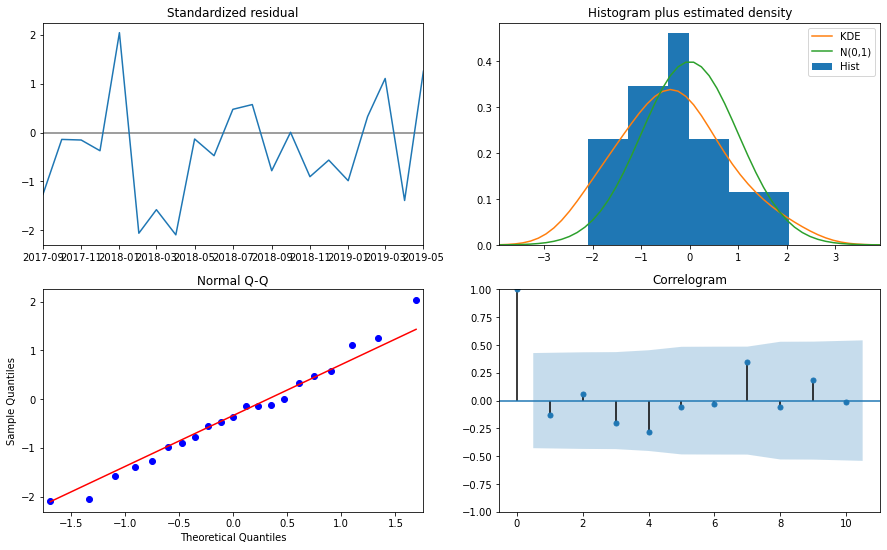

In [114]:
output.plot_diagnostics(figsize=(15,9));

## Make Predictions

In [115]:
history = [train[i] for i in range(len(train))]

predictions = []
for t in range(len(test)):
    yhat = predict(coef,history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmes = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 5374.870


In [116]:
pred = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_conf = pred.conf_int()

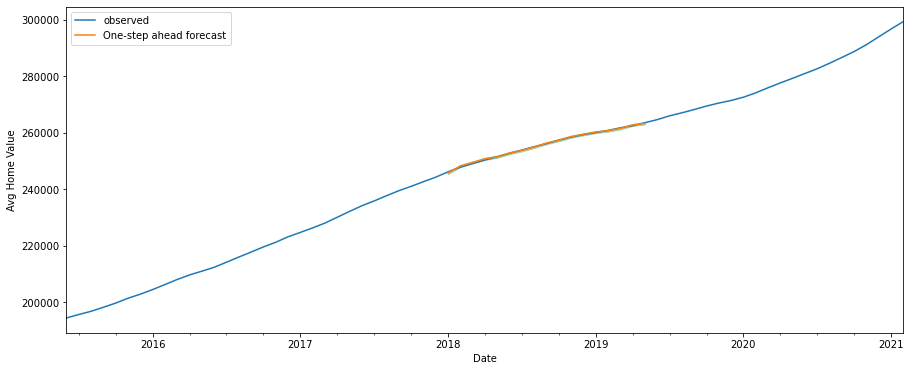

In [117]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast')

# plot confidence intervals
ax.fill_between(pred_conf.index,
               pred_conf.iloc[:,0],
               pred_conf.iloc[:,1], color='g', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [118]:
home_values_forecasted = pred.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((home_values_forecasted - home_values_true)**2).mean())
print(rmse)

242.74383493871514


## Dynamic Forecast

In [119]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

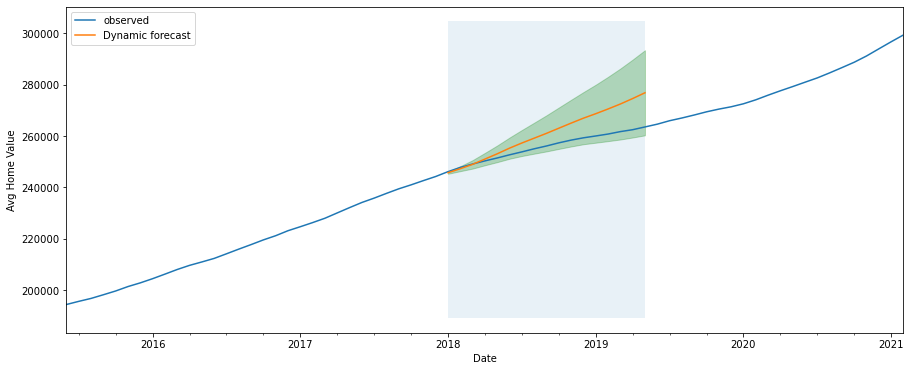

In [120]:
rcParams['figure.figsize'] = 15, 6

ax = home_values.plot(label='observed')

pred_dynamic.predicted_mean.plot(ax=ax, label='Dynamic forecast')

# plot confidence intervals
ax.fill_between(pred_dynamic_conf.index,
               pred_dynamic_conf.iloc[:,0],
               pred_dynamic_conf.iloc[:,1], color='g',alpha=0.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), home_values_forecasted.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Value')
plt.legend()
plt.show()

In [121]:
dyn_home_values_forecasted = pred_dynamic.predicted_mean
home_values_true = home_values['2018':]
rmse = np.sqrt(((dyn_home_values_forecasted - home_values_true)**2).mean())
print(rmse)

6898.743367884444


Much higher RMSE using a dynamic model.

# Alternate Method: Use Auto Arima

## Parameter Selection Using Auto Arima

In [162]:
from pmdarima.arima import auto_arima
step_wise=auto_arima(train, 
 exogenous= train_exog,
 start_p=1, start_q=1, 
 max_p=7, max_q=7, 
 d=1, max_d=7,
 trace=True, 
 error_action='ignore', 
 suppress_warnings=True, 
 stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=741.687, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=734.036, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=741.073, Time=0.34 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=719.438, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=746.179, Time=0.29 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=742.543, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=743.612, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=745.915, Time=0.14 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.035 seconds


In [163]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -352.719
Date:                Wed, 31 Mar 2021   AIC                            719.438
Time:                        14:47:28   BIC                            732.389
Sample:                    06-01-2015   HQIC                           724.311
                         - 05-01-2019                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept                      635.8559    201.878      3.150      0.002     240.183    1031.529
bathrooms                     7.391e+04   1.89e+04      3.905      0.000    3.68e+04    1.11e+05
number_of_reviews              531.0072    183.292      2.897      0.004     171.761     890.253
host_is_superhost               -1.5843      1.196     -1.324      0.185      -3.929       0.761
neighborhood_North_Nashville     7.5101      5.878      1.278      0.201      -4.010      19.030
ma.L1                           -0.1578      0.100     -1.576      0.115      -0.354       0.038
sigma2                        2.191e+05   8.45e+04      2.593      0.010    5.35e+04    3.85e+05
===================================================================================
Ljung-Box (Q):                      164.02   Jarque-Bera (JB):                 2.55
Prob(Q):                              0.00   Prob(JB):                         0.28
Heteroskedasticity (H):               1.02   Skew:                            -0.48
Prob(H) (two-sided):                  0.98   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Train the Model

In [164]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model= SARIMAX(train, 
               exog=train_exog,
               order=(0,1,1),
               enforce_invertibility=False, enforce_stationarity=False)

In [165]:
results = model.fit()

In [166]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         avg_home_value   No. Observations:                   48
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -336.271
Date:                Wed, 31 Mar 2021   AIC                            684.542
Time:                        14:48:25   BIC                            695.382
Sample:                    06-01-2015   HQIC                           688.583
                         - 05-01-2019                                         
Covariance Type:                  opg                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
bathrooms                     7.392e+04   1.46e+04      5.069      0.000    4.53e+04    1.02e+05
number_of_reviews             1016.1107    115.306      8.812      0.000     790.116    1242.106
host_is_superhost               -1.7271      0.677     -2.551      0.011      -3.054      -0.400
neighborhood_North_Nashville     7.6540      3.409      2.245      0.025       0.973      14.335
ma.L1                            0.8024      0.147      5.455      0.000       0.514       1.091
sigma2                        1.909e+05   5.82e+04      3.281      0.001    7.69e+04    3.05e+05
===================================================================================
Ljung-Box (Q):                       31.53   Jarque-Bera (JB):                15.26
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                            -1.03
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Make Predictions

In [174]:
steps = 0
predictions= results.predict(start = train_size, end=train_size+test_size+(steps)-1,exog=test_exog)

In [176]:
forecast_1= results.forecast(steps=test_size, exog=test_exog)

In [177]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_exog.index
predictions['Actual'] = test
predictions.rename(columns={0:'Pred'}, inplace=True)

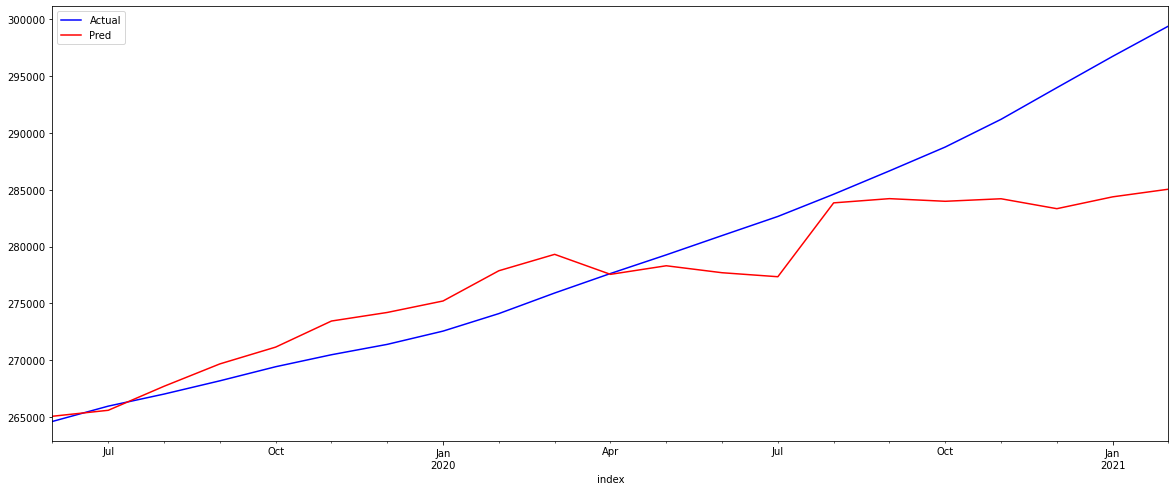

In [181]:
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))

In [182]:
from statsmodels.tools.eval_measures import rmse
error=rmse(predictions['Pred'], predictions['Actual'])
error

5539.658880053002